In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try: # Currently, memory growth needs to be the same across GPUs 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized print(e)
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
(train_X,train_Y),(test_X,test_Y)=tf.keras.datasets.mnist.load_data()
print(train_X.shape, train_Y.shape)
train_X=train_X/255
test_X=test_X/255
latent_size=64

(60000, 28, 28) (60000,)


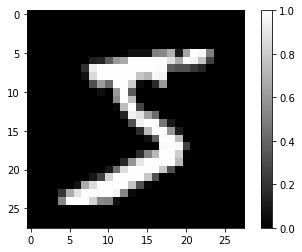

5


In [4]:
plt.imshow(train_X[0].reshape(28,28),cmap='gray')
plt.colorbar()
plt.show()
print(train_Y[0])

In [5]:
train_X=train_X.reshape(-1,28*28)
test_X=test_X.reshape(-1,28*28)
print(train_X.shape,train_Y.shape)

# Functional API
input_img=tf.keras.Input(shape=(784,))

# encoder
encoder1=tf.keras.layers.Dense(256,activation='relu')(input_img)
encoder2=tf.keras.layers.Dense(128,activation='relu')(encoder1)
encoder3=tf.keras.layers.Dense(latent_size,activation='relu')(encoder2)

# decoder
decoder1=tf.keras.layers.Dense(128,activation='relu')(encoder3)
decoder2=tf.keras.layers.Dense(256,activation='relu')(decoder1)
output_img=tf.keras.layers.Dense(784,activation='sigmoid')(decoder2)

# 모델 정의
autoencoder=tf.keras.Model(inputs=input_img,outputs=output_img)
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.fit(train_X,train_X,epochs=10,batch_size=256)

(60000, 784) (60000,)
Epoch 1/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0851A: 0s - lo
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0240
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0172
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0141
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0123
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0101
Epoch 8/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0093
Epoch 9/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0089
Epoch 10/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0084


In [7]:
# 인코더 모델 정의
encoder=tf.keras.Model(inputs=input_img,outputs=encoder3)
encoded_input=tf.keras.Input(shape=(latent_size,))

# 디코더 모델 정의
decoder_layer1=autoencoder.layers[-3](encoded_input)
decoder_layer2=autoencoder.layers[-2](decoder_layer1)
decoder_layer3=autoencoder.layers[-1](decoder_layer2)
decoder=tf.keras.Model(inputs=encoded_input,outputs=decoder_layer3)

In [9]:
# 잠재변수 값
latent_train=encoder.predict(train_X)
latent_test=encoder.predict(test_X)

# 재구성 값
reconstructed_imgs=decoder.predict(latent_test)

### 전이학습

In [18]:
# 원핫코딩
train_Y_onehot=tf.keras.utils.to_categorical(train_Y,num_classes=10)
test_Y_onehot=tf.keras.utils.to_categorical(test_Y,num_classes=10)

# Functional API
input_latent=tf.keras.Input(shape=(latent_size,))

# classifier
hidden=tf.keras.layers.Dense(32,activation='relu')(input_latent)
output_class=tf.keras.layers.Dense(10,activation='softmax')(hidden)

# 분류기 모델 정의
classifier=tf.keras.Model(inputs=input_latent, outputs=output_class)
classifier.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
history=classifier.fit(latent_train,train_Y_onehot,epochs=25,validation_split=0.25,callbacks=[tf.keras.callbacks.EarlyStopping()])

Epoch 1/25
1407/1407 [==============================] - 4s 2ms/step - loss: 1.6880 - accuracy: 0.6004 - val_loss: 0.3883 - val_accuracy: 0.8814
Epoch 2/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4086 - accuracy: 0.8757 - val_loss: 0.3441 - val_accuracy: 0.8943
Epoch 3/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3360 - accuracy: 0.8962 - val_loss: 0.3057 - val_accuracy: 0.9061
Epoch 4/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3059 - accuracy: 0.9070 - val_loss: 0.2707 - val_accuracy: 0.9192
Epoch 5/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2933 - accuracy: 0.9130 - val_loss: 0.2645 - val_accuracy: 0.9207
Epoch 6/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2668 - accuracy: 0.9196 - val_loss: 0.2485 - val_accuracy: 0.9248
Epoch 7/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2492 - accuracy: 0.9241 - val_loss: 0.2453 - val_accuracy:

In [20]:
# 성능 평가
classifier.evaluate(latent_test,test_Y_onehot,verbose=0)

[0.23074379563331604, 0.9312000274658203]